## Split and Modeling

**Index**

1. [Import libraries](#import-libraries)
2. [Import data](#import-data)
3. [Dataset Splitting](#Dataset-Splitting)
4. [Modeling and Model Evaluation](#Modeling-and-Model-Evaluation)
5. [Results and Selection of the Best Model](#Results-and-Selection-of-the-Best-Model)
6. [Save the trained model](#Save-the-trained-model)

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

from toolbox_ML import *
from bootcampviztools import *

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

### Import data

In [2]:
# Define the paths to the CSV files
data_folder = '../data_sample'
data_path = os.path.join(data_folder, 'data_final_preprocessed.csv')

In [3]:
# Read the CSV files
df = pd.read_csv(data_path)

### Dataset Splitting

In [4]:
# Define features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']


In [5]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(970, 15)
(970,)
(243, 15)
(243,)


In [7]:
# Normalization of numerical features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modeling and Model Evaluation

In [8]:
# I initialize all models with their default hyperparameters.
model_names = ["Logistic Regression","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_clf = LogisticRegression(max_iter = 10000)
tree_clf = DecisionTreeClassifier(random_state= 42)
rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)
cat_clf = CatBoostClassifier(random_state= 42, verbose = False)

In [9]:
# List with all models
model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]

In [10]:
# I compare all models using cross-validation.
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    #print(modelo)
    if nombre != "Logistic Regression":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "accuracy")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 3, scoring = "accuracy")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

In [11]:
#I check which model is the best after comparing them.
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El ganador es {ganador}")

Model <Logistic Regression>, Accuracy_CV: 0.8340245129890813
Model <DecisionTree>, Accuracy_CV: 0.8134037890659838
Model <Random Forest>, Accuracy_CV: 0.8979442979270981
Model <XGBoost>, Accuracy_CV: 0.86907401037088
Model <LightGBM>, Accuracy_CV: 0.8752659608352763
Model <CatBoost>, Accuracy_CV: 0.8876403062849572
El ganador es Random Forest


### Results and Selection of the Best Model

In [12]:
# I optimize the winning model.
rf_clf = RandomForestClassifier(random_state= 42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configure GridSearchCV
rf_grid = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Perform hyperparameter tuning
rf_grid.fit(X_train, y_train)

# Display the best found hyperparameters
print("Ramdon Forest best_score:", rf_grid.best_score_)
print("Best parameters found: ", rf_grid.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Ramdon Forest best_score: 0.9134020618556702
Best parameters found:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [13]:
# New model with modified hyperparameters
rf = RandomForestClassifier(    
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=200,
    random_state=42)

param_grid = {
    'n_estimators': [180, 200,250, 300,400,500],
    'min_samples_split': [3, 5, 7, 8],
    'min_samples_leaf': [1, -2, 0,-3],
    
}

# Configure GridSearchCV
rf_grid_2 = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Perform hyperparameter tuning
rf_grid_2.fit(X_train, y_train)

# Display the best found hyperparameters
print("Ramdon Forest best_score:", rf_grid_2.best_score_)
print("Best parameters found: ", rf_grid_2.best_params_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Ramdon Forest best_score: 0.9154639175257733
Best parameters found:  {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [14]:
# Model with the current best parameters
rf_3 = RandomForestClassifier(    
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=500,
    random_state=42
)

# Fine-tuning of hyperparameters
param_grid = {
    'n_estimators': [200, 300, 400, 500, 600],
    'min_samples_split': [3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [None, 10, 20, 30, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Configure GridSearchCV
rf_grid_3 = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Perform hyperparameter tuning
rf_grid_3.fit(X_train, y_train)

# Display the best found hyperparameters
print("Random Forest best_score:", rf_grid_3.best_score_)
print("Best parameters found: ", rf_grid_3.best_params_)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Random Forest best_score: 0.9164948453608248
Best parameters found:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 200}


              precision    recall  f1-score   support

           0       0.95      0.90      0.93       114
           1       0.92      0.96      0.94       129

    accuracy                           0.93       243
   macro avg       0.94      0.93      0.93       243
weighted avg       0.94      0.93      0.93       243



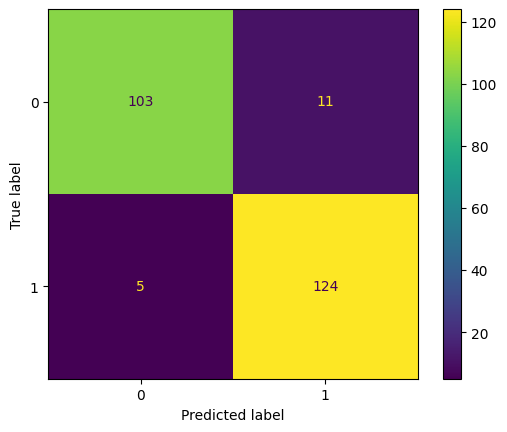

In [15]:
# Analysis with the third trained model

# Predictions from trained model 3
y_pred_3 = rf_grid_3.best_estimator_.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred_3))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_3)

The third model, despite showing slight improvement over the first, gives the same results when evaluated on the test set. Therefore, I will disregard these changes and keep the first trained model.

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       114
           1       0.92      0.96      0.94       129

    accuracy                           0.93       243
   macro avg       0.94      0.93      0.93       243
weighted avg       0.94      0.93      0.93       243



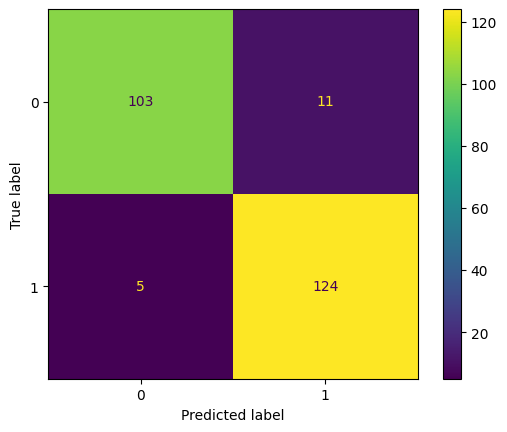

In [16]:
# Study of the initial model

# Predictions from the trained model
y_pred = rf_grid.best_estimator_.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

This is the study I will consider when saving the model.

In [17]:
# Identify the false negatives
false_negatives_mask = (y_test == 1) & (y_pred == 0)
false_negatives = X_test[false_negatives_mask]
false_negatives_indices = np.where(false_negatives_mask)[0]

In [18]:
print(f"Number of false negatives: {len(false_negatives_indices)}")
print("Indices of false negatives:", false_negatives_indices)

Number of false negatives: 5
Indices of false negatives: [ 37  76 115 183 192]


In [19]:
# Showing the data of false negatives as a DataFrame
false_negatives_df = X_test.iloc[false_negatives_indices]
print("Datos de los falsos negativos:")
false_negatives_df

Datos de los falsos negativos:


,Age,Cholesterol,MaxHR,Oldpeak,RestingBP,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_Y,FastingBS_True,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,Sex_M
1092,41,172.0,158.0,0.0,110.0,False,False,False,False,False,False,False,False,True,True
607,41,239.0,176.0,1.6,125.0,False,False,False,False,True,True,False,False,True,True
57,41,172.0,158.0,0.0,110.0,False,False,False,False,False,False,False,False,True,True
735,52,239.0,180.0,3.0,128.0,False,True,False,False,False,False,True,False,True,True
842,61,200.0,100.0,1.5,142.0,False,False,True,False,True,False,True,False,False,True


In [20]:
# Viewing the corresponding true labels, i.e., those that had a true result in HeartDisease
false_negatives_labels = y_test.iloc[false_negatives_indices]
print("Etiquetas verdaderas de los falsos negativos:")
false_negatives_labels

Etiquetas verdaderas de los falsos negativos:


1092    1
607     1
57      1
735     1
842     1
Name: HeartDisease, dtype: int64

It seems there's nothing exceptional or special at first glance in the cases where the predictor failed. Most of them are individuals around 41 years old, and interestingly, they are all men. It would be wise to pay closer attention to these cases of men aged between 40 and 60 years old.

### Save the trained model

In [21]:
import pickle

model_folder = "../model"
pickle_file = os.path.join(model_folder, "best_rf_model.pkl")
with open(pickle_file, 'wb') as file:
    pickle.dump(rf_grid, file)


------
